# EDA

In [2]:
import pybgpstream
import pandas as pd

## Cloudflare 1.1.1.1 incident on June 27, 2024

https://blog.cloudflare.com/cloudflare-1111-incident-on-june-27-2024/

Some of the difficulty comes from potential routing hijacks of 1.1.1.1. For example, if some fictitious FooBar Networks assigns 1.1.1.1/32 to one of their routers and shares this prefix within their internal network, their customers will have difficulty routing to the 1.1.1.1 DNS service. If they advertise the 1.1.1.1/32 prefix outside their immediate network, the impact can be even greater. The reason 1.1.1.1/32 would be selected instead of the 1.1.1.0/24 BGP-announced by Cloudflare is due to Longest Prefix Matching (LPM). While many prefixes in a route table could match the 1.1.1.1 address, such as 1.1.1.0/24, 1.1.1.0/29, and 1.1.1.1/32, 1.1.1.1/32 is considered the “longest match” by the LPM algorithm because it has the highest number of identical bits and longest subnet mask while matching the 1.1.1.1 address. In simple terms, we would call 1.1.1.1/32 the “most specific” route available to 1.1.1.1.

- **2024-06-27 18:51:00** `AS267613` (Eletronet) begins announcing 1.1.1.1/32 to peers, providers, and customers. 1.1.1.1/32 is announced with the AS267613 origin AS

- **2024-06-27 22:16:00** AS262504 leaks 1.1.1.0/24 again, attracting some traffic to a Cloudflare peering with `AS267613` in São Paulo. Some 1.1.1.1 requests as a result are returned with higher latency, but the hijack of 1.1.1.1/32 and traffic blackholing appears resolved

### Get data

In [ ]:
# collector = "route-views.eqix"
# collector = "route-views.ny" 
# collector = "route-views.telxatl"
# collector = "route-views2.saopaulo"
# collector = "route-views.fortaleza"
collector = "route-views.amsix"

stream = pybgpstream.BGPStream(
    #project="route-views",          # Proyecto
    collectors  =   [collector],#     # Collector remoto
    record_type =   "updates",             # "ribs" o "updates"
    from_time   =   "2024-06-27 18:00:00",  # Inicio del rango
    until_time  =   "2024-06-27 22:30:00",     # Fin del rango (aquí 5 minutos)
)

""" rows = []

# Iterar sobre los registros en tiempo real o históricos
for rec in stream.records():
    for elem in rec:
        fields = elem.fields
        rows.append({
            "time": rec.time,
            "project": rec.project,
            "collector": rec.collector,
            "peer_asn": fields.get("peer-asn"),
            "peer_ip": fields.get("peer-address"),
            "type": elem.type,           # "RIB", "A" (announce), "W" (withdraw)
            "prefix": fields.get("prefix"),
            "next_hop": fields.get("next-hop"),
            "as_path": fields.get("as-path"),
            "origin": fields.get("origin"),
            "local_pref": fields.get("local-pref"),
            "med": fields.get("med"),
            "communities": fields.get("communities"),
        }) """

rows = []

for rec in stream.records():
    for elem in rec:
        f = elem.fields  # solo atributos BGP (no peers)

        # Para retiros (W) no hay as-path/next-hop/etc.
        is_announce = (elem.type == 'A')

        rows.append({
            "time": rec.time,                        # epoch (int)
            "project": rec.project,                  # p.ej. "route-views"
            "collector": rec.collector,              # p.ej. "route-views.sg"
            "peer_asn": elem.peer_asn,               # <--- AQUÍ
            "peer_ip": elem.peer_address,            # <--- AQUÍ
            "type": elem.type,                       # "A" o "W"
            "prefix": f.get("prefix"),
            "next_hop": f.get("next-hop") if is_announce else None,
            "as_path": f.get("as-path")  if is_announce else None,
            "origin": f.get("origin")    if is_announce else None,
            "local_pref": f.get("local-pref") if is_announce else None,
            "med": f.get("med")                  if is_announce else None,
            "communities": f.get("communities") if is_announce else None,
        })

# Convertir a DataFrame
df = pd.DataFrame(rows)

#pd.set_option('display.max_rows', None)

print(f'Dataframe with {len(df):,} rows')

Dataframe with 11,628,213 rows


In [3]:
df['formatted_time'] = pd.to_datetime(df['time'], unit='s', utc=True)
df['formatted_time'] = df['formatted_time'].dt.strftime('%Y-%m-%d %H:%M:%S')
df.head(5)

,time,project,collector,peer_asn,peer_ip,type,prefix,next_hop,as_path,origin,local_pref,med,communities,formatted_time
0,1.719511e+09,routeviews,route-views.amsix,267613,2001:7f8:1:0:a500:26:7613:1,A,2804:1070::/32,2001:7f8:1:0:a500:26:7613:1,267613 28209,None,None,None,"{5469:11111, 5469:2400, 5469:10110}",2024-06-27 18:00:00
1,1.719511e+09,routeviews,route-views.amsix,267613,2001:7f8:1:0:a500:26:7613:1,A,2804:1624:9000::/36,2001:7f8:1:0:a500:26:7613:1,267613 174 263444 263270,None,None,None,"{5469:10850, 5469:11000, 5469:2200}",2024-06-27 18:00:00
2,1.719511e+09,routeviews,route-views.amsix,267613,2001:7f8:1:0:a500:26:7613:1,A,2a06:de05:61dc::/48,2001:7f8:1:0:a500:26:7613:1,267613 1299 174 53667,None,None,None,"{5469:10850, 5469:11000, 5469:2200}",2024-06-27 18:00:00
3,1.719511e+09,routeviews,route-views.amsix,56662,2001:7f8:f2:e1:0:a105:6662:1,A,2a06:de05:61dc::/48,2001:7f8:f2:e1:0:a105:6662:1,56662 34549 3257 174 53667,None,None,None,{56662:65008},2024-06-27 18:00:00
4,1.719511e+09,routeviews,route-views.amsix,213151,2001:7f8:f2:e1:0:21:3151:1,A,2a06:de05:61dc::/48,2001:7f8:f2:e1:0:21:3151:1,213151 34549 3257 174 53667,None,None,None,{},2024-06-27 18:00:00


#### Save data

In [4]:
df.to_parquet(f'/home/chris/projects/BGP Hijacking detection/data/raw/cloudflare_june_27_2024_{collector}.parquet',
              engine='pyarrow',
              compression='zstd')

In [5]:
del df

## Load data from file

### Route Views EQIX

In [ ]:
collector = "route-views.eqix"

df_eqix = pd.read_parquet(f'/home/chris/projects/BGP Hijacking detection/data/raw/cloudflare_june_27_2024_{collector}.parquet',
                             engine='pyarrow')

df_eqix.head(10)

,time,project,collector,peer_asn,peer_ip,type,prefix,next_hop,as_path,origin,local_pref,med,communities,formatted_time
0,1.719511e+09,routeviews,route-views.eqix,37468,206.126.238.56,A,169.145.140.0/23,206.126.238.64,37468 8220 14114 6979 6979 6979 6979 6979 6979,None,None,None,"[37468:2410, 37468:2000, 37468:14102, 37468:14...",2024-06-27 18:00:00
1,1.719511e+09,routeviews,route-views.eqix,3257,206.126.236.19,W,45.172.92.0/22,None,None,None,None,None,None,2024-06-27 18:00:00
2,1.719511e+09,routeviews,route-views.eqix,3257,2001:504:0:2::3257:1,A,2a10:ccc7:9367::/48,2001:504:0:2::3257:1,3257 2914 2914 2914 20473,None,None,None,"[3257:51105, 3257:50002, 3257:8162, 3257:51100...",2024-06-27 18:00:00
3,1.719511e+09,routeviews,route-views.eqix,6939,2001:504:0:2::6939:1,A,2c0f:fda8::/32,2001:504:0:2::6939:1,6939 37662 9498 36926 327708 37133 37349,None,None,None,[],2024-06-27 18:00:00
4,1.719511e+09,routeviews,route-views.eqix,41095,206.126.236.120,W,197.216.52.0/24,None,None,None,None,None,None,2024-06-27 18:00:00
5,1.719511e+09,routeviews,route-views.eqix,41095,206.126.236.120,W,81.192.239.0/24,None,None,None,None,None,None,2024-06-27 18:00:00
6,1.719511e+09,routeviews,route-views.eqix,41095,206.126.236.120,W,66.22.107.0/24,None,None,None,None,None,None,2024-06-27 18:00:00
7,1.719511e+09,routeviews,route-views.eqix,41095,206.126.236.120,W,195.34.196.0/22,None,None,None,None,None,None,2024-06-27 18:00:00
8,1.719511e+09,routeviews,route-views.eqix,41095,206.126.236.120,W,194.177.24.0/22,None,None,None,None,None,None,2024-06-27 18:00:00
9,1.719511e+09,routeviews,route-views.eqix,41095,206.126.236.120,W,193.108.226.0/23,None,None,None,None,None,None,2024-06-27 18:00:00


In [4]:
df_eqix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7240184 entries, 0 to 7240183
Data columns (total 14 columns):
 #   Column          Dtype  
---  ------          -----  
 0   time            float64
 1   project         object 
 2   collector       object 
 3   peer_asn        int64  
 4   peer_ip         object 
 5   type            object 
 6   prefix          object 
 7   next_hop        object 
 8   as_path         object 
 9   origin          object 
 10  local_pref      object 
 11  med             object 
 12  communities     object 
 13  formatted_time  object 
dtypes: float64(1), int64(1), object(12)
memory usage: 773.3+ MB


In [5]:
null_stats = pd.DataFrame({
    'nulos': df_eqix.isna().sum(),
    'no_nulos': df_eqix.notna().sum(),
    'pct_nulos': (df_eqix.isna().sum() / len(df_eqix) * 100).round(2)
})
print(null_stats)

                  nulos  no_nulos  pct_nulos
time                  0   7240184       0.00
project               0   7240184       0.00
collector             0   7240184       0.00
peer_asn              0   7240184       0.00
peer_ip               0   7240184       0.00
type                  0   7240184       0.00
prefix                0   7240184       0.00
next_hop         460296   6779888       6.36
as_path          460296   6779888       6.36
origin          7240184         0     100.00
local_pref      7240184         0     100.00
med             7240184         0     100.00
communities      460296   6779888       6.36
formatted_time        0   7240184       0.00


In [6]:
df_eqix[df_eqix['prefix'] == '1.1.1.1/32' ]

,time,project,collector,peer_asn,peer_ip,type,prefix,next_hop,as_path,origin,local_pref,med,communities,formatted_time
1465049,1.719514e+09,routeviews,route-views.eqix,398465,206.126.236.209,A,1.1.1.1/32,206.126.236.209,398465 267613,None,None,None,[],2024-06-27 18:52:57
2193539,1.719516e+09,routeviews,route-views.eqix,398465,206.126.236.209,W,1.1.1.1/32,None,None,None,None,None,None,2024-06-27 19:16:27
2267139,1.719516e+09,routeviews,route-views.eqix,398465,206.126.236.209,A,1.1.1.1/32,206.126.236.209,398465 267613,None,None,None,[],2024-06-27 19:18:59
2777146,1.719517e+09,routeviews,route-views.eqix,398465,206.126.236.209,W,1.1.1.1/32,None,None,None,None,None,None,2024-06-27 19:41:47
2853716,1.719518e+09,routeviews,route-views.eqix,398465,206.126.236.209,A,1.1.1.1/32,206.126.236.209,398465 267613,None,None,None,[],2024-06-27 19:46:01
3418875,1.719519e+09,routeviews,route-views.eqix,398465,206.126.236.209,W,1.1.1.1/32,None,None,None,None,None,None,2024-06-27 20:07:48
3538161,1.719519e+09,routeviews,route-views.eqix,398465,206.126.236.209,A,1.1.1.1/32,206.126.236.209,398465 267613,None,None,None,[],2024-06-27 20:11:49
4090674,1.719520e+09,routeviews,route-views.eqix,398465,206.126.236.209,W,1.1.1.1/32,None,None,None,None,None,None,2024-06-27 20:33:25


In [7]:
df_eqix_as_267613 = df_eqix[df_eqix['as_path'].str.contains('267613', na=False)]
df_eqix_as_267613.head(20)

,time,project,collector,peer_asn,peer_ip,type,prefix,next_hop,as_path,origin,local_pref,med,communities,formatted_time
33723,1.719511e+09,routeviews,route-views.eqix,3257,206.126.236.19,A,138.219.97.0/24,206.126.236.19,3257 3356 267613 263922,None,None,None,"[3257:50002, 3257:8156, 3257:30049, 3257:51102...",2024-06-27 18:01:24
33724,1.719511e+09,routeviews,route-views.eqix,3257,206.126.236.19,A,138.219.96.0/24,206.126.236.19,3257 3356 267613 263922,None,None,None,"[3257:50002, 3257:8156, 3257:30049, 3257:51102...",2024-06-27 18:01:24
33725,1.719511e+09,routeviews,route-views.eqix,3257,206.126.236.19,A,138.219.99.0/24,206.126.236.19,3257 3356 267613 263922,None,None,None,"[3257:50002, 3257:8156, 3257:30049, 3257:51102...",2024-06-27 18:01:24
37913,1.719511e+09,routeviews,route-views.eqix,6939,206.126.236.37,A,190.105.197.0/24,206.126.236.37,6939 267613 262462 270842,None,None,None,[],2024-06-27 18:01:34
37914,1.719511e+09,routeviews,route-views.eqix,6939,206.126.236.37,A,190.105.198.0/24,206.126.236.37,6939 267613 262462 270842,None,None,None,[],2024-06-27 18:01:34
56245,1.719511e+09,routeviews,route-views.eqix,6939,2001:504:0:2::6939:1,A,2804:5c18::/32,2001:504:0:2::6939:1,6939 267613 263250 268887,None,None,None,[],2024-06-27 18:02:00
56383,1.719511e+09,routeviews,route-views.eqix,11039,2001:504:0:2:0:1:1039:1,A,2804:5c18::/32,2001:504:0:2::6939:1,11039 6939 267613 263250 268887,None,None,None,[],2024-06-27 18:02:00
56402,1.719511e+09,routeviews,route-views.eqix,398465,2001:504:0:2:0:39:8465:1,A,2804:5c18::/32,2001:504:0:2:0:39:8465:1,398465 6939 267613 263250 268887,None,None,None,[],2024-06-27 18:02:00
63079,1.719511e+09,routeviews,route-views.eqix,293,2001:504:0:2::293:1,A,2804:5c18::/32,2001:504:0:2::293:1,293 6939 267613 263250 268887,None,None,None,[],2024-06-27 18:02:16
234311,1.719512e+09,routeviews,route-views.eqix,19151,206.126.236.47,A,45.181.100.0/22,206.126.236.47,19151 174 267613 269182,None,None,None,[],2024-06-27 18:05:44


In [8]:
len(df_eqix_as_267613['as_path'].to_list()[6].split())

5

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [10]:
def plot_counts_per_type(df_: pd.DataFrame):
    df = df_.copy()
    df_types = (
        df['type']
        .value_counts()
        .reset_index()
    )

    display(df_types)

    plt.figure(figsize=(10,6))
    ax = sns.barplot(data=df_types, x='type', y='count', palette='Set2', hue='type')
    plt.title('Counts per Type')
    plt.xlabel('Type')
    plt.ylabel('Count')
    plt.show()

,type,count
0,A,6779888
1,W,460296


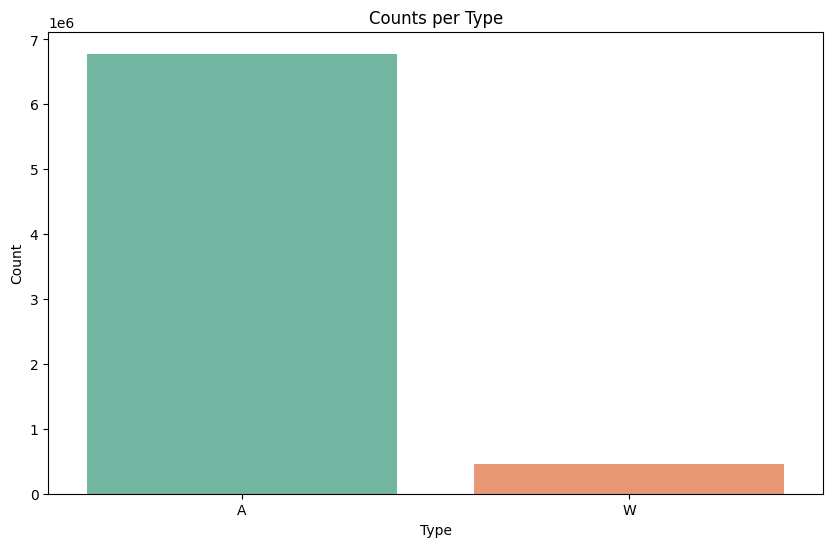

In [11]:
plot_counts_per_type(df_eqix)

In [12]:
def plot_updates_by_type(df_: pd.DataFrame, grain: str = "1min", group_col: str = None):
    """
    Grafica la distribución temporal de eventos BGP por tipo (A/W).
    
    Parámetros
    ----------
    df : pd.DataFrame
        Debe incluir las columnas: ['formatted_time', 'type'].
        'formatted_time' puede ser string '%Y-%m-%d %H:%M:%S' o datetime.
    grain : str
        Frecuencia de agregación temporal (p.ej. '1S', '1min', '5min', '1H').
    group_col : str, opcional
        Nombre de una columna del DataFrame. Si se especifica, se generará un
        gráfico por cada valor distinto de esa columna (small multiples).
        Si no se especifica, se grafica una sola serie agregada globalmente.

    Returns
    -------
    pd.DataFrame
        DataFrame agregado con columnas:
        - Si group_col es None: ['t', 'type', 'count']
        - Si group_col no es None: ['t', group_col, 'type', 'count']
    """

    df = df_.copy()
    if group_col is None:
        # Agregado global por tiempo y tipo
        df['formatted_time'] = pd.to_datetime(df['formatted_time'], utc=True, errors='coerce')
        agg = (
            df.groupby([pd.Grouper(key='formatted_time', freq=grain), 'type'])
                .size()
                .reset_index(name='count')
                .sort_values('formatted_time')
        )

        # Plot único (A vs W)
        plt.figure(figsize=(12, 5))
        sns.lineplot(data=agg, x='formatted_time', y='count', hue='type', estimator=None)
        plt.title(f'Eventos BGP por tipo (A/W) en el tiempo — {grain}')
        plt.xlabel('Tiempo'); plt.ylabel('Número de eventos')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

    else:

        if isinstance(df[group_col].dtype, pd.CategoricalDtype):
            df[group_col] = df[group_col].cat.remove_unused_categories()
        # Agregado por tiempo, grupo y tipo
        agg = (
            df.groupby([pd.Grouper(key='formatted_time', freq=grain), group_col, 'type'])
                .size()
                .reset_index(name='count')
                .sort_values('formatted_time')
        )

        # Small multiples: un panel por valor de group_col
        g = sns.FacetGrid(
            agg, col=group_col, hue='type', sharey=False, sharex=True, col_wrap=3, height=3.2, aspect=1.6
        )
        g.map_dataframe(sns.lineplot, x='formatted_time', y='count', estimator=None)
        g.add_legend(title='type')
        g.set_xticklabels(rotation=30)
        g.set_axis_labels('Tiempo', 'Número de eventos')
        g.set_titles(col_template=f'{group_col} = {{col_name}}')
        for ax in g.axes.flatten():
            ax.grid(True, alpha=0.3)
        plt.subplots_adjust(top=0.88)
        g.fig.suptitle(f'Eventos BGP por tipo (A/W) en el tiempo — {grain}', y=1.02)
        plt.tight_layout()
        plt.show()

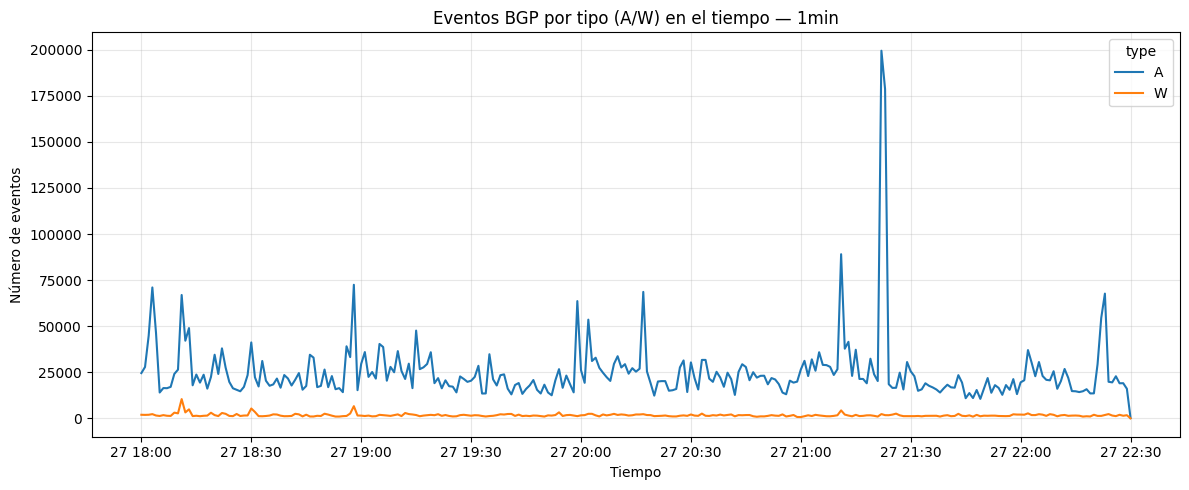

In [13]:
plot_updates_by_type(df_eqix, grain='1min')

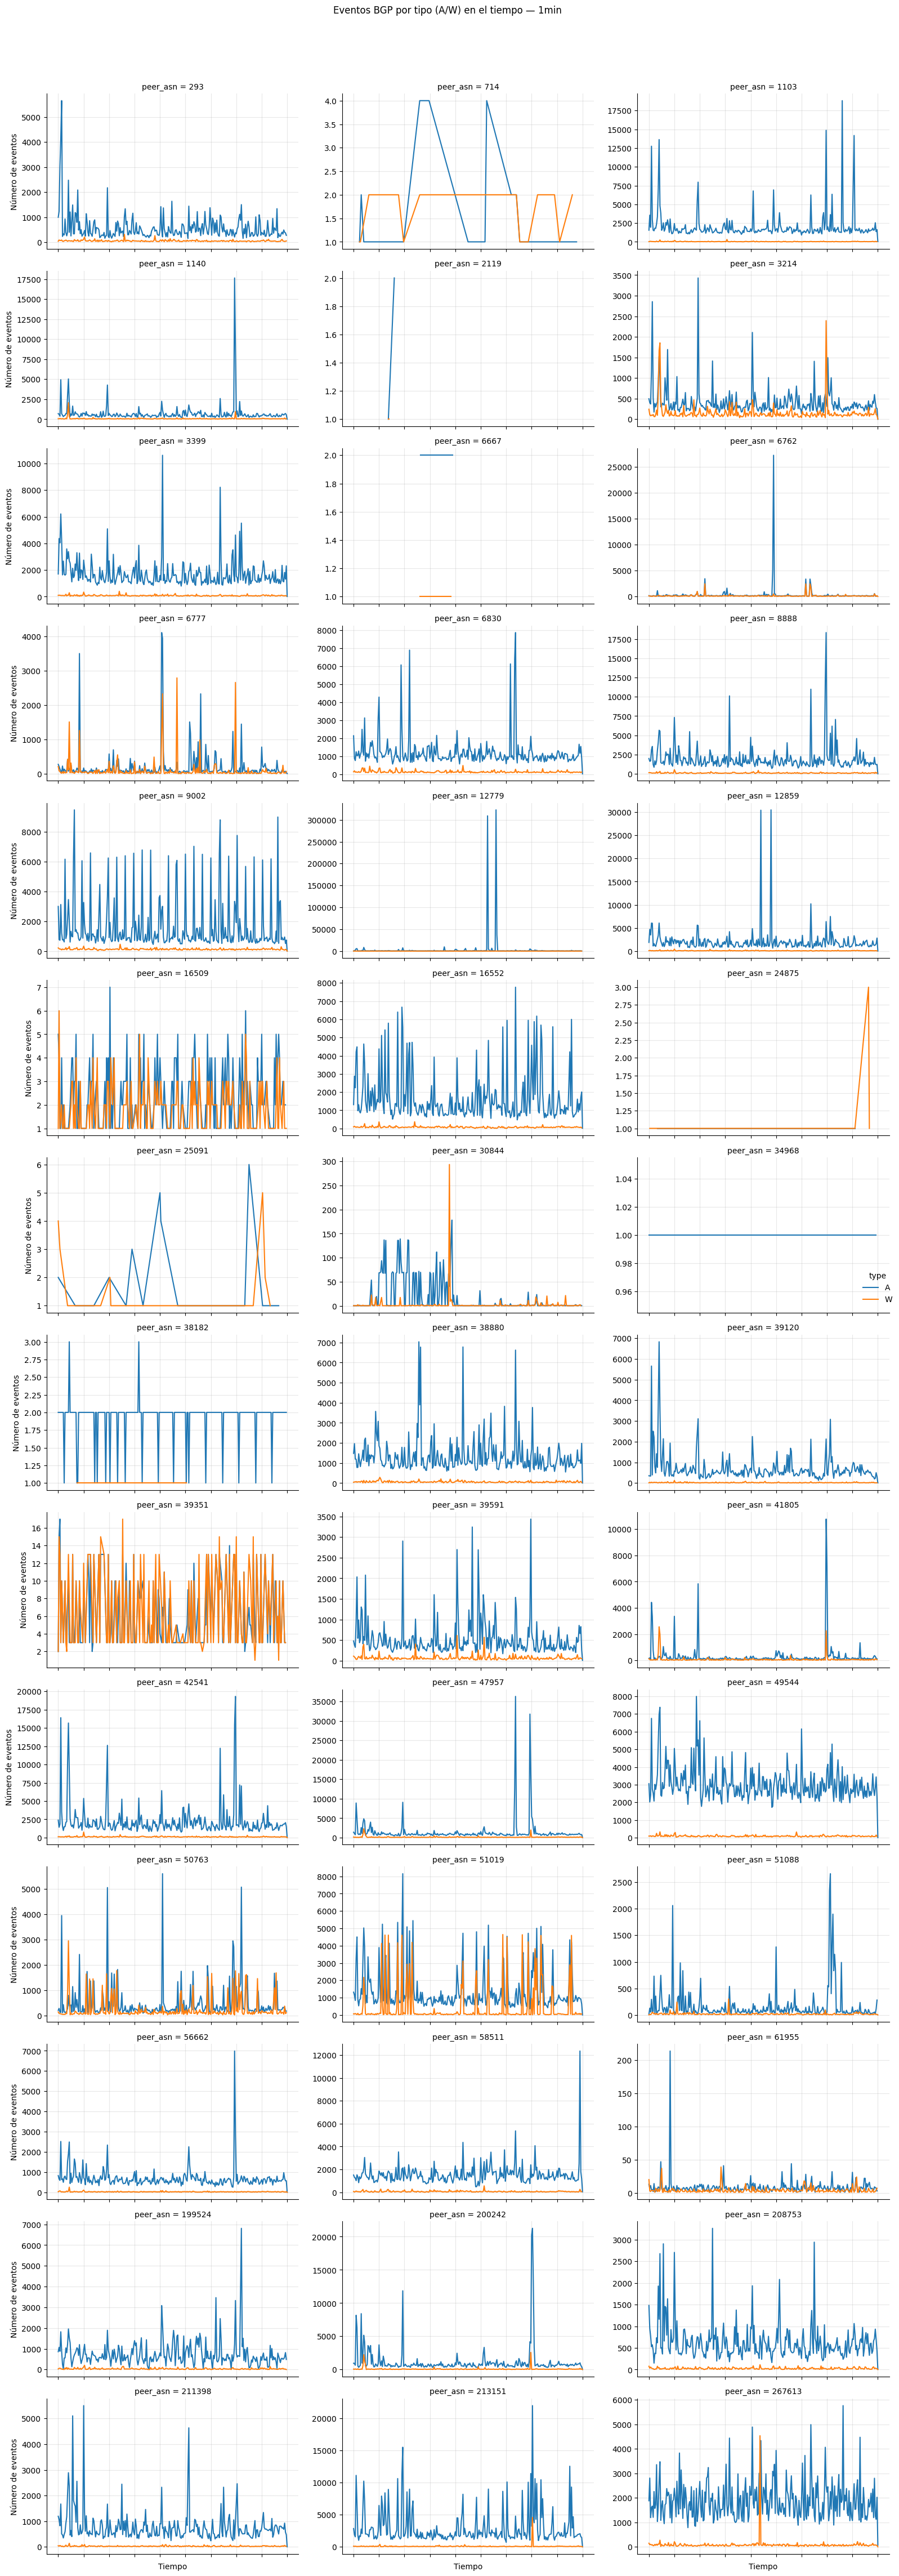

In [ ]:
plot_updates_by_type(df_eqix, grain='1min', group_col='peer_asn')

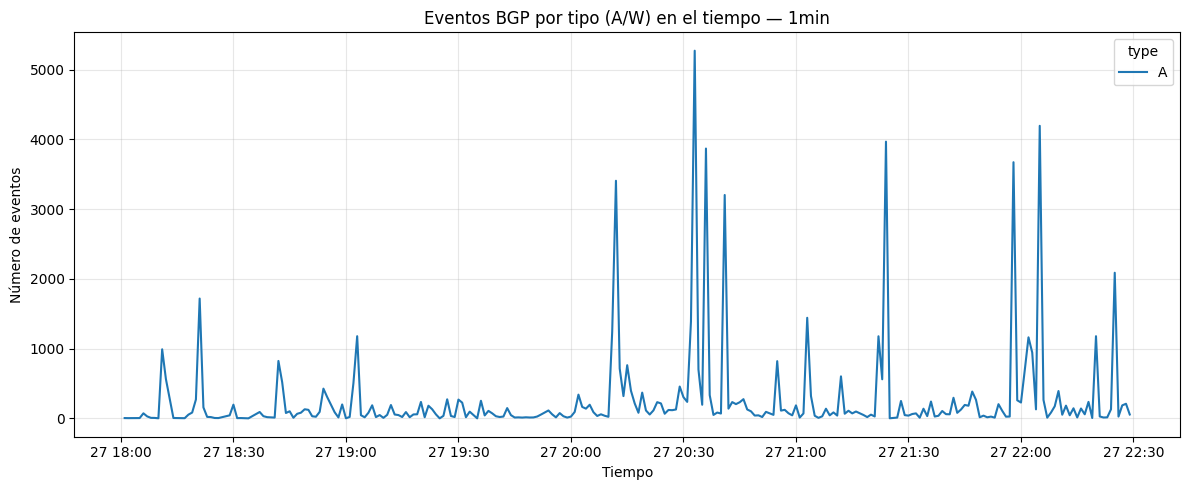

In [ ]:
plot_updates_by_type(df_eqix_as_267613, grain='1min')

### Route Views AMSIX

In [ ]:
collector = "route-views.amsix"

df_eqix = pd.read_parquet(f'/home/chris/projects/BGP Hijacking detection/data/raw/cloudflare_june_27_2024_{collector}.parquet',
                             engine='pyarrow')

df_eqix.head(10)

df_eqix.info()

null_stats = pd.DataFrame({
    'nulos': df_eqix.isna().sum(),
    'no_nulos': df_eqix.notna().sum(),
    'pct_nulos': (df_eqix.isna().sum() / len(df_eqix) * 100).round(2)
})
print(null_stats)

df_eqix[df_eqix['prefix'] == '1.1.1.1/32' ]

df_eqix_as_267613 = df_eqix[df_eqix['as_path'].str.contains('267613', na=False)]
df_eqix_as_267613.head(20)

### Route Views FORTALEZA

In [ ]:
collector = "route-views.fortaleza"

df_eqix = pd.read_parquet(f'/home/chris/projects/BGP Hijacking detection/data/raw/cloudflare_june_27_2024_{collector}.parquet',
                             engine='pyarrow')

df_eqix.head(10)

df_eqix.info()

null_stats = pd.DataFrame({
    'nulos': df_eqix.isna().sum(),
    'no_nulos': df_eqix.notna().sum(),
    'pct_nulos': (df_eqix.isna().sum() / len(df_eqix) * 100).round(2)
})
print(null_stats)

df_eqix[df_eqix['prefix'] == '1.1.1.1/32' ]

df_eqix_as_267613 = df_eqix[df_eqix['as_path'].str.contains('267613', na=False)]
df_eqix_as_267613.head(20)

### Route Views NY

In [ ]:
collector = "route-views.ny"

df_eqix = pd.read_parquet(f'/home/chris/projects/BGP Hijacking detection/data/raw/cloudflare_june_27_2024_{collector}.parquet',
                             engine='pyarrow')

df_eqix.head(10)

df_eqix.info()

null_stats = pd.DataFrame({
    'nulos': df_eqix.isna().sum(),
    'no_nulos': df_eqix.notna().sum(),
    'pct_nulos': (df_eqix.isna().sum() / len(df_eqix) * 100).round(2)
})
print(null_stats)

df_eqix[df_eqix['prefix'] == '1.1.1.1/32' ]

df_eqix_as_267613 = df_eqix[df_eqix['as_path'].str.contains('267613', na=False)]
df_eqix_as_267613.head(20)

### Route Views TELXATL

In [ ]:
collector = "route-views.telxatl"

df_eqix = pd.read_parquet(f'/home/chris/projects/BGP Hijacking detection/data/raw/cloudflare_june_27_2024_{collector}.parquet',
                             engine='pyarrow')

df_eqix.head(10)

df_eqix.info()

null_stats = pd.DataFrame({
    'nulos': df_eqix.isna().sum(),
    'no_nulos': df_eqix.notna().sum(),
    'pct_nulos': (df_eqix.isna().sum() / len(df_eqix) * 100).round(2)
})
print(null_stats)

df_eqix[df_eqix['prefix'] == '1.1.1.1/32' ]

df_eqix_as_267613 = df_eqix[df_eqix['as_path'].str.contains('267613', na=False)]
df_eqix_as_267613.head(20)

### Route Views SAOPAULO

In [ ]:
collector = "route-views2.saopaulo"

df_eqix = pd.read_parquet(f'/home/chris/projects/BGP Hijacking detection/data/raw/cloudflare_june_27_2024_{collector}.parquet',
                             engine='pyarrow')

df_eqix.head(10)

df_eqix.info()

null_stats = pd.DataFrame({
    'nulos': df_eqix.isna().sum(),
    'no_nulos': df_eqix.notna().sum(),
    'pct_nulos': (df_eqix.isna().sum() / len(df_eqix) * 100).round(2)
})
print(null_stats)

df_eqix[df_eqix['prefix'] == '1.1.1.1/32' ]

df_eqix_as_267613 = df_eqix[df_eqix['as_path'].str.contains('267613', na=False)]
df_eqix_as_267613.head(20)